In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

!pip install gdown
!pip install transformers
!pip install sentencepiece # MarianTokenizer 불러올 때 필요
!pip install einops # Einstein operations -> 텐서연산을 간단하게 하기 위한 라이브러리

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [21]:
import torch
import torch.nn as nn
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import MarianTokenizer
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## 토크나이저 사용해보기


In [3]:
# BPE기반의 MarianTokenizer 불러오기
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')

# 토크나이저에서 eos, pad 토큰 출력해보기
eos_idx = tokenizer.eos_token_id # eos토큰을 sos토큰으로도 사용한다.
pad_idx = tokenizer.pad_token_id
print("eos_idx = ", eos_idx)
print("pad_idx = ", pad_idx)

eos_idx =  0
pad_idx =  65000


In [4]:
print(tokenizer.tokenize("리오넬 메시는 8개의 발롱도르를 수상했다."))
print(tokenizer.tokenize("바르셀로나는 세계 최고의 팀이다."))
# print(tokenizer.get_vocab())
print(tokenizer.vocab_size)
print(tokenizer.encode('바람', add_special_tokens=False))
print(tokenizer.encode('<pad>', add_special_tokens=False))
print(tokenizer.encode('</s>', add_special_tokens=False))
print(tokenizer.decode([204]))
print(tokenizer.decode([206]))

['▁', '리오', '넬', '▁메', '시는', '▁8', '개의', '▁발', '롱', '도르', '를', '▁수상', '했다', '.']
['▁', '바르셀로나', '는', '▁세계', '▁최고의', '▁팀이', '다', '.']
65001
[8429]
[65000]
[0]
사람
으로


## Data Loader

In [7]:
# 데이터 불러오기
!pip install openpyxl
!gdown https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t -O '대화체.xlsx'
data = pd.read_excel('대화체.xlsx')

Defaulting to user installation because normal site-packages is not writeable
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Downloading...
From: https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t
To: /home/jinwon/workspace/5-plm/Transformer/대화체.xlsx
100%|██████████████████████████████████████| 9.57M/9.57M [00:01<00:00, 9.09MB/s]


In [97]:
# 하이퍼파라미터 정의
BATCH_SIZE = 64
EPOCH = 15
max_len = 100
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) # pad token이 출력 나와야하는 시점의 loss는 무시 (즉, label이 <pad> 일 때는 무시)

vocab_size = tokenizer.vocab_size

# 논문 원본
n_layers = 6
d_model = 512
d_ff = 2048
n_heads = 8
drop_p = 0.1

# 좀 사이즈 줄인 모델 (훈련된 input_embedding, fc_out 사용하면 사용 불가)
# n_layers = 3
# d_model = 256 # 차원
# d_ff = 512
# n_heads = 8
# drop_p = 0.1

In [98]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000, 2000, 1000]) # 논문에서는 450만개의 영어-독일어 문장 pair 사용함.

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [99]:
# test_DL 확인
i = 1
src_text, trg_text = test_DS[i]

print(f"인덱스: {test_DS.indices[i]}")
print(f"원문: {src_text}")
print(f"번역문: {trg_text}")

인덱스: 27492
원문: 투어 일정을 변경하려고 하는데, 수수료가 있나요?
번역문: I want to change the tour schedule, do I need to pay the extra fee?


In [100]:
# train_DL 확인
for src_texts, trg_texts in train_DL:
    # Source Sentence
    src = tokenizer(src_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt', add_special_tokens = False).input_ids
    # Target Sentence
    trg_texts = ['</s> ' + s for s in trg_texts] # 모든 문장의 앞에 </s>를 추가
    trg = tokenizer(trg_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids

    print(src.shape)
    print(trg.shape)
    print(tokenizer.decode(trg[trg[:,-1]==eos_idx,:][0])) # 가장 긴 문장 중 첫 번째 문장 출력

    break

torch.Size([64, 23])
torch.Size([64, 51])
</s> Hello? I'm calling from room 1711. The television seems like it's broken because the sound doesn't work.</s>


# 모델 구현

## Multi-Head Attention

In [108]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads
        
        # Query, Key, Value 추출
        self.fc_q = nn.Linear(d_model, d_model) 
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        # 스케일링
        self.scale = torch.sqrt(torch.tensor(d_model / n_heads)) 

    def forward(self, Q, K, V, mask = None):

        Q = self.fc_q(Q) # (64, 단어수, 512)
        K = self.fc_k(K)
        V = self.fc_v(V)

        Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads) # (64, 단어수, (8x64)) -> (64, 8, 단어수, 512)
        K = rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads) # (64, 단어수, (8x64)) -> (64, 8, 단어수, 512)
        V = rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads) # (64, 단어수, (8x64)) -> (64, 8, 단어수, 512)

        attention_score = Q @ K.transpose(-2,-1)/self.scale # (64, 8, 단어수, 512) x (64, 8, 512, 단어수) = (64, 8, 단어수, 단어수)

        if mask is not None:
            attention_score[mask] = -1e10

        attention_weights = torch.softmax(attention_score, dim=-1) # (64, 8, 단어수, 단어수)

        attention = attention_weights @ V # (64, 8, 단어수, 512)

        x = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # (64, 단어수, 512) / concat까지 einops에서 알아서
        x = self.fc_o(x) # (64, 단어수, 512)

        return x
    

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p),
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

## Encoder

In [113]:
# Positional Encoding 구현
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * -(math.log(10000.0) / d_model))

        encoding[:, 0::2] = torch.sin(position * div_term)  # 짝수 인덱스
        encoding[:, 1::2] = torch.cos(position * div_term)  # 홀수 인덱스

        self.encoding = encoding.unsqueeze(0)  # (1, max_len, 512)

    def forward(self, x):
        seq_len = x.size(1)  # 입력의 시퀀스 길이
        x = x + self.encoding[:, :seq_len, :].to(x.device)
        return self.dropout(x)

In [109]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):

        residual = self.self_atten(x, x, x, enc_mask) 
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x

class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.input_embedding = input_embedding
        self.positional_encoding = PositionalEncoding(d_model, max_len, drop_p)  # Positional Encoding 추가
        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

    def forward(self, src, mask):
        # Word Embedding
        x = self.input_embedding(src)  # (64, 단어수, 512)

        # Positional Encoding과 결합
        x = self.positional_encoding(x)  # (64, 단어수, 512)
        x = self.dropout(x)

        # Encoder Layers
        for layer in self.layers: # 6층의 layer 통과
            x = layer(x, mask)

        return x # k, v로 사용

## Decoder

In [110]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.enc_dec_atten = MHA(d_model, n_heads)
        self.enc_dec_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):

        residual = self.self_atten(x, x, x, dec_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual = self.enc_dec_atten(x, enc_out, enc_out, enc_dec_mask) # Q는 디코더로부터 K,V는 인코더로부터.
        residual = self.dropout(residual)
        x = self.enc_dec_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x

class Decoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p, vocab_size):
        super().__init__()

        self.input_embedding = input_embedding
        self.positional_encoding = PositionalEncoding(d_model, max_len, drop_p)  # Positional Encoding 추가
        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

        self.fc_out = nn.Linear(d_model, vocab_size)  # 최종 출력 레이어 (512, 65001)

    def forward(self, trg, enc_out, dec_mask, enc_dec_mask):  # trg.shape = (64, 단어수), enc_out.shape = (64, 단어수, 512)
        # Word Embedding
        x = self.input_embedding(trg)  # (64, 단어수, 512)

        # Positional Encoding과 결합
        x = self.positional_encoding(x)  # (64, 단어수, 512)
        x = self.dropout(x)

        # Decoder Layers
        for layer in self.layers: # 6층의 layer 통과
            x = layer(x, enc_out, dec_mask, enc_dec_mask)

        # 최종 출력
        x = self.fc_out(x)

        return x


## 모델 전체

In [111]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.input_embedding = nn.Embedding(vocab_size, d_model) # 코드 구현에서 조금 아쉬운 부분, 한글과 영어 모두(65001)개를 한꺼번에 임베딩 통과
        self.encoder = Encoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)
        self.decoder = Decoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

        self.n_heads = n_heads

        # 논문에 직접적인 언급은 없지만, 일반적으로 트랜스포머 구현에서 Xavier Initialization 방법이 많이 사용됨.
        for m in self.modules():
            if hasattr(m,'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight)

    def make_enc_mask(self, src): # src.shape = (64, 단어수)

        enc_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2) # (64, 1, 1, 단어수)
        enc_mask = enc_mask.expand(src.shape[0], self.n_heads, src.shape[1], src.shape[1]) # (64, 8, 단어수, 단어수)
        """ src pad mask (문장 마다 다르게 생김. 이건 한 문장에 대한 pad 행렬)
        F F T T
        F F T T
        F F T T
        F F T T
        """
        return enc_mask

    def make_dec_mask(self, trg): # trg.shape = (64, 단어수)

        trg_pad_mask = (trg == pad_idx).unsqueeze(1).unsqueeze(2) # (64, 1, 1, 단어수)
        trg_pad_mask = trg_pad_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1]) # (64, 8, 단어수, 단어수)
        """ trg pad mask
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        """
        trg_future_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1]))==0 # (64, 8, 단어수, 단어수)
        trg_future_mask = trg_future_mask.to(DEVICE) # pad_mask | future_mask 할 때 같은 DEVICE 여야 함
        """ trg future mask
        F T T T T
        F F T T T
        F F F T T
        F F F F T
        F F F F F
        """
        dec_mask = trg_pad_mask | trg_future_mask # dec_mask.shape = (64, 8, 단어수, 단어수)
        """ decoder mask
        F T T T T
        F F T T T
        F F F T T
        F F F T T
        F F F T T
        """
        return dec_mask

    def make_enc_dec_mask(self, src, trg):

        enc_dec_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2) # (64, 1, 1, 단어수)
        enc_dec_mask = enc_dec_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], src.shape[1]) # (64, 8, 단어수, 단어수)
        """ src pad mask
        F F T T
        F F T T
        F F T T
        F F T T
        F F T T
        """
        return enc_dec_mask

    def forward(self, src, trg):

        enc_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(trg)
        enc_dec_mask = self.make_enc_dec_mask(src, trg)

        enc_out, atten_encs = self.encoder(src, enc_mask)
        out, atten_decs, atten_enc_decs = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)

        return out, atten_encs, atten_decs, atten_enc_decs

In [112]:
model = Transformer(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p).to(DEVICE)

src = torch.tensor([[4,6,5,1,1,1],[7,7,1,1,1,1]]).to(DEVICE)
trg = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)

model.eval()
with torch.no_grad():
    x = model(src, trg)[0]
print(trg.shape)
print(x.shape)

torch.Size([2, 7])
torch.Size([2, 7, 65001])


## 논문에서 사용된 Noam Scheduler 구현

$$
lrate = d_{\text{model}}^{-0.5} \cdot \min\left(\text{step\_num}^{-0.5}, \text{step\_num} \cdot \text{warmup\_steps}^{-1.5}\right)
$$

In [114]:
class NoamScheduler: # custom scheduler 정의
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale = 1):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = self.LR_scale * (self.d_model ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5) 
        # 논문에 수식 구현
        self.optimizer.param_groups[0]['lr'] = lrate
        # 여기가 핵심, step이라는 함수를 call했을 때 업데이트 할 값을 넣어줘야 함.

def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps:
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    if scheduler_name == 'Noam':
        if total_steps == 100000:
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) ** -0.5, 'g--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$")
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) * 4000 ** -1.5, 'r--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$")
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    elif scheduler_name == 'Cos': # 논문에서 사용된 또 다른 스케줄러인 CosineAnnealingWarmRestarts
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

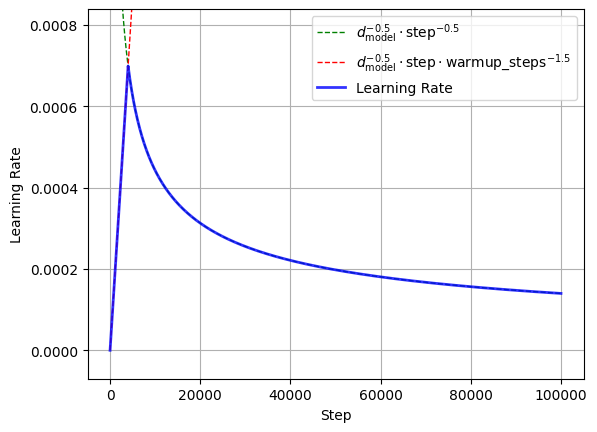

In [115]:
optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0) # 테스트용 optimizer
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000) # 논문 값
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = 100000)